<a href="https://colab.research.google.com/github/DLSHW/autoencoders/blob/master/autoencoders_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from copy import deepcopy
import glob
import os

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


from time import time
import datetime

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos =df['photo_path'].apply(Image.open)\
                                .apply(np.asarray)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize((dimx, dimy))
))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
data.shape

(13143, 45, 45, 3)

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[:TRAIN_SIZE] 
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE] 

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest') 
            plt.xticks(())
            plt.yticks(())
        except:
            pass
    plt.show()

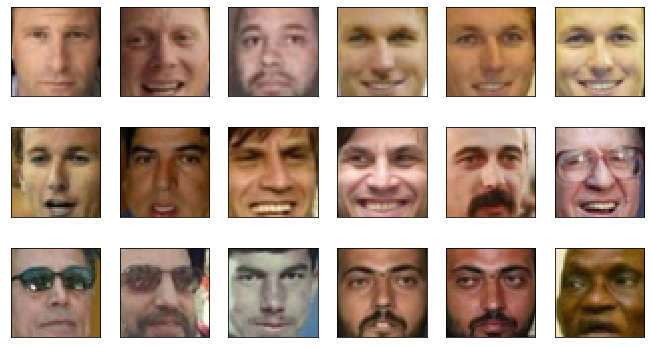

In [ ]:
plot_gallery(X_train, h=45, w=45)

In [ ]:
# визуализация лосса
def visualize(train_loss, val_loss):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
X_train = torch.FloatTensor(data[:TRAIN_SIZE]).permute((0, 3, 1, 2))
X_val = torch.FloatTensor(data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]).permute((0, 3, 1, 2))

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size = X_train.size()[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder>
        self.encoder = nn.Sequential(
            nn.Conv2d(inp_size, 25, kernel_size=3, stride=1, padding=1), # 3x45x45 -> 25x45x45
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 25x45x45 -> 25x22x22
            nn.Conv2d(25, 50, kernel_size=3, stride=1, padding=1), # 25x22x22 -> 50x22x22
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 50x22x22 -> 50x11x11
            nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1), # 50x11x11 -> 100x11x11
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 100x11x11 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=5, stride=1, padding=0), # 100x5x5 -> 100x1x1
            nn.BatchNorm2d(100),
            nn.ReLU()
        ) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(1, 1), output_padding=(0, 0)), # 100x1x1 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1), # 100x5x5 -> 100x5x5
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 100, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 100x5x5 -> 100x11x11
            nn.Conv2d(100, 50, kernel_size=3, stride=1, padding=1), # 100x11x11 -> 50x11x11
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 50, kernel_size=(2, 2), stride=(2, 2)), # 50x11x11 -> 50x22x22
            nn.Conv2d(50, 25, kernel_size=3, stride=1, padding=1), # 50x22x22 -> 25x22x22
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.ConvTranspose2d(25, 25, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 25x22x22 -> 25x45x45
            nn.Conv2d(25, inp_size, kernel_size=3, stride=1, padding=1) # 25x45x45 -> 3x45x45
        )


    def forward(self, x):
        
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x) 
        reconstruction = self.decoder(latent_code)
        return reconstruction

In [ ]:
criterion = nn.MSELoss() 
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4) 

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __getitem__(self, index):
        item_X = self.X[index, :, :, :] / 255
        return item_X

    def __len__(self):
        return self.X.size()[0]

batch_size = 5

dataset = ImageDataset(X=X_train)

val_dataset = ImageDataset(X=X_val)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
autoencoder.load_state_dict(torch.load('gdrive/My Drive/vanilla_autoencoder200epoch.pth'))

|Epoch 200/200| |Time_left: 0:00:34.701352|


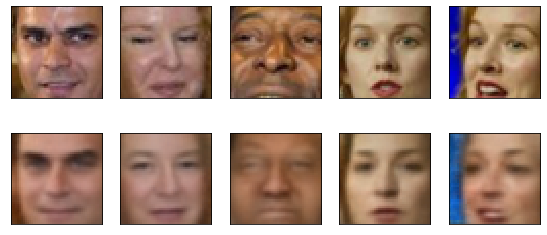

In [ ]:
# <тут Ваш код тренировки автоэнкодера>
num_epoch = 200

train_losses = []
val_losses = []

prev_time = time()

x_val = next(iter(val_dataloader)).to(device)

for epoch in range(num_epoch):
    epoch_train_losses = []
    for X_train_batch in train_dataloader:
      X_train_batch = X_train_batch.to(device)
      autoencoder.train()
      optimizer.zero_grad()
      rec_img = autoencoder(X_train_batch)
      train_loss = criterion(rec_img, X_train_batch)
      train_loss.backward()
      optimizer.step()
      epoch_train_losses.append(train_loss.item())
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for X_val_batch in val_dataloader:
        X_val_batch = X_val_batch.to(device)
        autoencoder.eval()
        pred_img = autoencoder(X_val_batch)
        val_loss = criterion(pred_img, X_val_batch)
        epoch_val_losses.append(val_loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    
    clear_output(wait=True)
    time_left = datetime.timedelta(seconds=(num_epoch - epoch)*(time() - prev_time))
    prev_time = time()
    print("\r|Epoch {}/{}| |Time_left: {}|". \
          format(epoch+1,
                num_epoch,
                time_left
      )
    )
    reconstruction = np.rollaxis(autoencoder(x_val).detach().cpu().numpy(), 1, 4)
    plot_gallery(np.concatenate([np.rollaxis(x_val.detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)
  

In [ ]:
torch.save(autoencoder.state_dict(), "gdrive/My Drive/vanilla_autoencoder200epoch.pth")

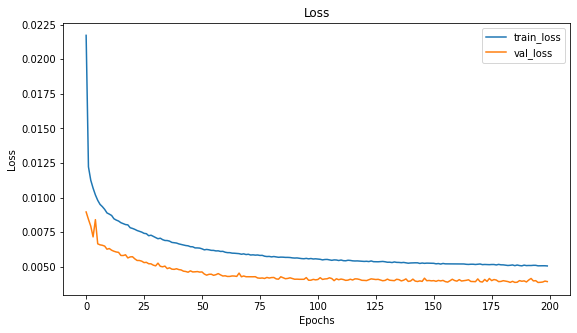

In [ ]:
visualize(train_losses, val_losses)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

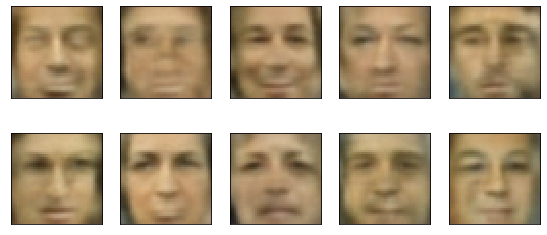

In [ ]:
# beta-распрелеление
rand_vec_output = autoencoder.decoder(torch.FloatTensor(np.random.beta(1, 1, (10, 100, 1, 1))).to(device))
plot_gallery(np.rollaxis(rand_vec_output.detach().cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


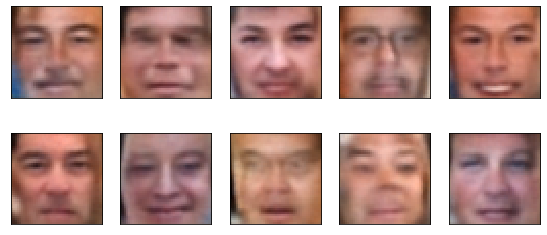

In [ ]:
# биномиальное распрелеление
rand_vec_output = autoencoder.decoder(torch.FloatTensor(np.random.binomial(2, 0.5, (10, 100, 1, 1))).to(device))
plot_gallery(np.rollaxis(rand_vec_output.detach().cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


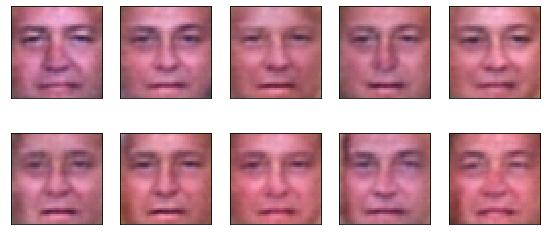

In [ ]:
# логнормальное распределение
rand_vec_output = autoencoder.decoder(torch.FloatTensor(np.random.lognormal(0.5, 0.3, (10, 100, 1, 1))).to(device))
plot_gallery(np.rollaxis(rand_vec_output.detach().cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=5)

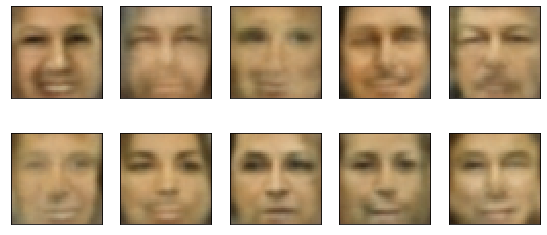

In [ ]:
# степенное распределение
rand_vec_output = autoencoder.decoder(torch.FloatTensor(np.random.power(1, (10, 100, 1, 1))).to(device))
plot_gallery(np.rollaxis(rand_vec_output.detach().cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=5)

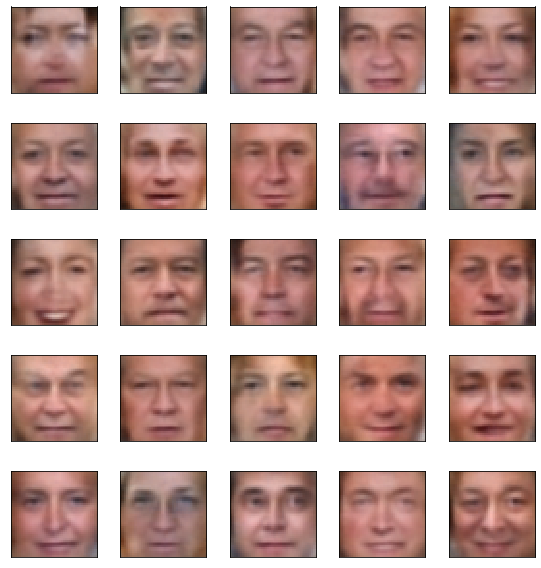

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# нормальное распределение с параметрами mean = 1, std = 0.5
z = torch.FloatTensor(np.random.normal(1, 0.5, (25, 100, 1, 1))).to(device) # <latent_space_dim> = 100x1x1
output = autoencoder.decoder(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
df = attrs[['Smiling', 'photo_path']].sort_values(by=['Smiling'], ascending=True)

In [ ]:
sad = df['photo_path'].head(30)
smile = df['photo_path'].tail(30)

In [ ]:
def photo_preprocessing(df,
                        dx=80,dy=80,
                        dimx=45,dimy=45):
    photos = df.apply(Image.open)\
               .apply(np.asarray)\
               .apply(lambda img:img[dy:-dy,dx:-dx])\
               .apply(lambda img: np.array(Image.fromarray(img).resize((dimx, dimy))
    ))
    photos = np.stack(photos.values).astype('uint8')
    photos = torch.FloatTensor(photos).permute((0, 3, 1, 2))
    return photos

In [ ]:
sad = photo_preprocessing(sad)
smile = photo_preprocessing(smile)                     

In [ ]:
batch_size = 1

sad_dataset = ImageDataset(X=sad)
smile_dataset = ImageDataset(X=smile)

sad_dataloader = torch.utils.data.DataLoader(sad_dataset, batch_size=batch_size, shuffle=True)
smile_dataloader = torch.utils.data.DataLoader(smile_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# <а вот тут все это надо запрогать, да>
autoencoder.eval()
avg_smile_vec = torch.zeros(batch_size, 100, 1, 1).to(device)
avg_sad_vec = torch.zeros(batch_size, 100, 1, 1).to(device)

for smile_pic, sad_pic in zip(smile_dataloader, sad_dataloader):
  avg_smile_vec += autoencoder.encoder(smile_pic.to(device))
  avg_sad_vec += autoencoder.encoder(sad_pic.to(device))
  
avg_smile_vec = avg_smile_vec / len(smile_dataloader)
avg_sad_vec = avg_sad_vec / len(sad_dataloader)

div_vec = avg_smile_vec - avg_sad_vec


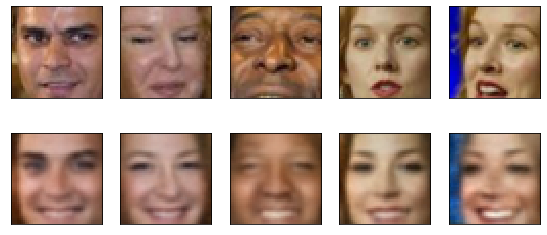

In [ ]:
x_val = next(iter(val_dataloader)).to(device)
smiling_vec = autoencoder.encoder(x_val) + div_vec
smiling_reconstruction = autoencoder.decoder(smiling_vec)

reconstruction = np.rollaxis(smiling_reconstruction.detach().cpu().numpy(), 1, 4)
plot_gallery(np.concatenate([np.rollaxis(x_val.detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder>
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 25, kernel_size=3, stride=1, padding=1), # 3x45x45 -> 25x45x45
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 25x45x45 -> 25x22x22
            nn.Conv2d(25, 50, kernel_size=3, stride=1, padding=1), # 25x22x22 -> 50x22x22
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 50x22x22 -> 50x11x11
            nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1), # 50x11x11 -> 100x11x11
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 100x11x11 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=(3, 5), stride=(2, 1), padding=(0, 0)), # 100x5x5 -> 100x2x1
            nn.BatchNorm2d(100),
            nn.ReLU()
        ) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(1, 1), output_padding=(0, 0)), # 100x1x1 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1), # 100x5x5 -> 100x5x5
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 100, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 100x5x5 -> 100x11x11
            nn.Conv2d(100, 50, kernel_size=3, stride=1, padding=1), # 100x11x11 -> 50x11x11
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 50, kernel_size=(2, 2), stride=(2, 2)), # 50x11x11 -> 50x22x22
            nn.Conv2d(50, 25, kernel_size=3, stride=1, padding=1), # 50x22x22 -> 25x22x22
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.ConvTranspose2d(25, 25, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 25x22x22 -> 25x45x45
            nn.Conv2d(25, 3, kernel_size=3, stride=1, padding=1) # 25x45x45 -> 3x45x45
        )
        self.fc1 = nn.Sequential(
            nn.Linear(100, 100)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(100, 100)
        )


    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        mu = self.fc1(x[:, :, 0, :].squeeze(2))
        logsigma = self.fc2(x[:, :, 1, :].squeeze(2))
        mu = mu.unsqueeze(2).unsqueeze(3)
        logsigma = logsigma.unsqueeze(2).unsqueeze(3)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_() 
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>
        reconstruction = torch.sigmoid(self.decoder(z))
        return reconstruction

    def forward(self, x):
        
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_code)
        return mu, logsigma, reconstruction



In [ ]:
class ImageDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __getitem__(self, index):
        item_X = self.X[index, :, :, :] / 255
        return item_X

    def __len__(self):
        return self.X.size()[0]

batch_size = 10

dataset = ImageDataset(X=X_train)

val_dataset = ImageDataset(X=X_val)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum((1 + torch.log(torch.exp(logsigma)**2) - mu**2 - torch.exp(logsigma)**2)) # <напишите код для KL-дивергенции, пользуясь формулой выше>

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum') # <binary cross-entropy>

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()


И обучим модель:

In [ ]:
criterion = loss_vae
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

In [ ]:
vae.load_state_dict(torch.load('gdrive/My Drive/vae_autoencoder.pth'))

In [ ]:
num_epoch = 200

train_losses = []
val_losses = []

prev_time = time()

x_val = next(iter(val_dataloader)).to(device)

for epoch in range(num_epoch):
    epoch_train_losses = []
    for X_train_batch in train_dataloader:
      X_train_batch = X_train_batch.to(device)
      vae.train()
      optimizer.zero_grad()
      mu, logsigma, rec_img = vae(X_train_batch)
      
      train_loss = criterion(X_train_batch, mu, logsigma, rec_img)
      train_loss.backward()
      optimizer.step()
      epoch_train_losses.append(train_loss.item())
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for X_val_batch in val_dataloader:
        X_val_batch = X_val_batch.to(device)
        vae.eval()
        mu, logsigma, pred_img = vae(X_val_batch)
        val_loss = criterion(X_val_batch, mu, logsigma, pred_img)
        epoch_val_losses.append(val_loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    
    clear_output(wait=True)
    time_left = datetime.timedelta(seconds=(num_epoch - epoch)*(time() - prev_time))
    prev_time = time()
    print("\r|Epoch {}/{}| |Time_left: {}|". \
          format(epoch+1,
                num_epoch,
                time_left
      )
    )
    
    # print('Mean: {}, logsigma: {}'.format(mu.mean(), logsigma.mean()))

|Epoch 200/200| |Time_left: 0:00:24.167947|
Mean: -0.011644947342574596, logsigma: -0.2904696762561798


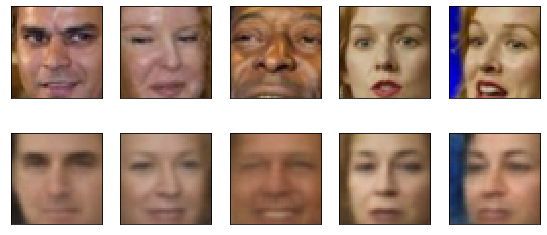

In [ ]:
reconstruction = np.rollaxis(vae(x_val)[2][0:5].detach().cpu().numpy(), 1, 4)
plot_gallery(np.concatenate([np.rollaxis(x_val[0:5].detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)

In [ ]:
torch.save(vae.state_dict(), "gdrive/My Drive/vae_autoencoder200epoch.pth")

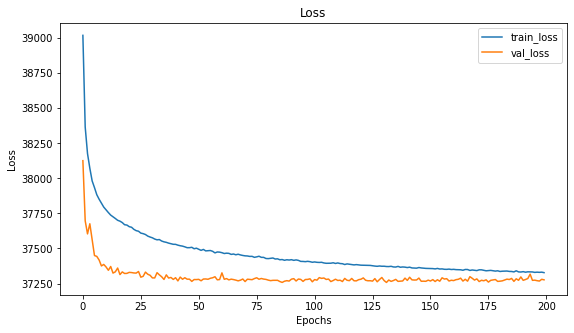

In [ ]:
visualize(train_losses, val_losses)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

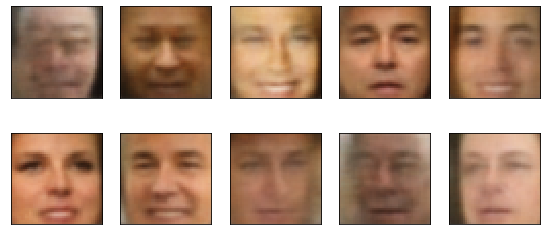

In [ ]:
vae.eval()
z = torch.FloatTensor(np.random.normal(0, 1, (10, 100, 1, 1))).to(device) # <latent_space_dim> = 100x1x1
output = vae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
color = np.array((attrs.iloc[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]['Male'] < 0).astype('int'))

In [ ]:
latent_vecs = pd.DataFrame()
vae.eval()
for i, X_val_batch in enumerate(val_dataloader):
  X_val_batch = X_val_batch.to(device)
  mu, logsigma = vae.encode(X_val_batch)
  encoded = vae.gaussian_sampler(mu, logsigma).detach().squeeze(3).squeeze(2).cpu().numpy()
  if i == 0:
    encoded_to_conc = encoded
  else:
    encoded_to_conc = np.concatenate((encoded_to_conc, encoded), axis=0)
  X_val_batch.cpu()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_to_conc)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

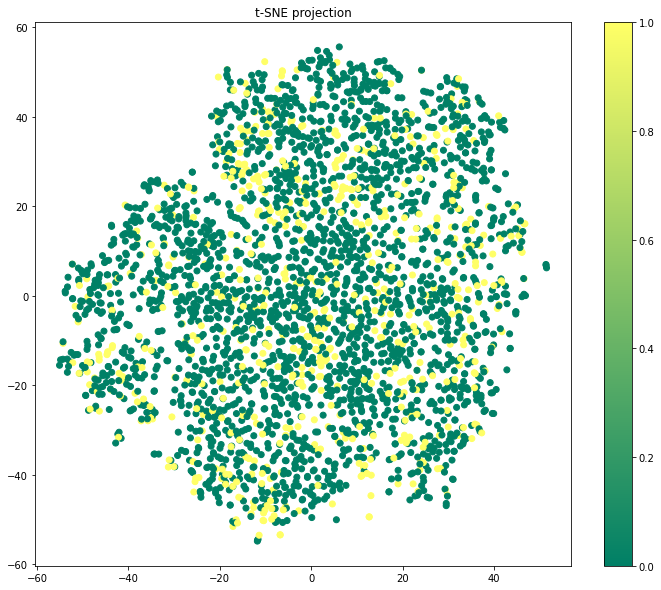

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap = 'summer')
plt.colorbar()
plt.title('t-SNE projection')
plt.show()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
color = torch.FloatTensor((attrs['Male'] < 0).astype('int'))
train_male_class = color[0:TRAIN_SIZE]
val_male_class = color[TRAIN_SIZE:VAL_SIZE + TRAIN_SIZE ]

In [ ]:
X_train_c = torch.FloatTensor(X_train.size()).copy_(X_train)
X_val_c = torch.FloatTensor(X_val.size()).copy_(X_val)

In [ ]:
for idx in range(X_train_c.size()[0]):
  X_train_c[idx, :, 44, 44] = train_male_class[idx]
for idx in range(X_val_c.size()[0]):
  X_val_c[idx, :, 44, 44] = val_male_class[idx]


In [ ]:
class CImageDataset(Dataset):
    def __init__(self, X, class_labels):
        self.X = X
        self.labels = class_labels

    def __getitem__(self, index):
        item_X = self.X[index, :, :, :] / 255
        item_labels = self.labels[index]
        return {'A': item_X, 'B': item_labels}

    def __len__(self):
        return self.X.size()[0]

batch_size = 5

dataset = CImageDataset(X=X_train_c, class_labels=train_male_class)
val_dataset = CImageDataset(X=X_val_c, class_labels=val_male_class)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum((1 + torch.log(torch.exp(logsigma)**2) - mu**2 - torch.exp(logsigma)**2)) # <напишите код для KL-дивергенции, пользуясь формулой выше>

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum') # <binary cross-entropy>

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder>
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 25, kernel_size=3, stride=1, padding=1), # 3x45x45 -> 25x45x45
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 25x45x45 -> 25x22x22
            nn.Conv2d(25, 50, kernel_size=3, stride=1, padding=1), # 25x22x22 -> 50x22x22
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 50x22x22 -> 50x11x11
            nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1), # 50x11x11 -> 100x11x11
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # 100x11x11 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=(3, 5), stride=(2, 1), padding=(0, 0)), # 100x5x5 -> 100x2x1
            nn.BatchNorm2d(100),
            nn.ReLU()
        ) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(101, 100, kernel_size=(5, 5), stride=(1, 1), output_padding=(0, 0)), # 101x1x1 -> 100x5x5
            nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1), # 100x5x5 -> 100x5x5
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 100, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 100x5x5 -> 100x11x11
            nn.Conv2d(100, 50, kernel_size=3, stride=1, padding=1), # 100x11x11 -> 50x11x11
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 50, kernel_size=(2, 2), stride=(2, 2)), # 50x11x11 -> 50x22x22
            nn.Conv2d(50, 25, kernel_size=3, stride=1, padding=1), # 50x22x22 -> 25x22x22
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.ConvTranspose2d(25, 25, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 1)), # 25x22x22 -> 25x45x45
            nn.Conv2d(25, 3, kernel_size=3, stride=1, padding=1) # 25x45x45 -> 3x45x45
        )

        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        mu = self.fc1(x[:, :, 0, :].squeeze(2)).unsqueeze(2).unsqueeze(3)
        logsigma = self.fc2(x[:, :, 1, :].squeeze(2)).unsqueeze(2).unsqueeze(3)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma, class_label):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_() 
            latent_vec =  eps.mul(std).add_(mu)
        else:
            latent_vec =  mu
        latent_vec = torch.cat([latent_vec.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3)
        return latent_vec
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>
        reconstruction = torch.sigmoid(self.decoder(z))
        return reconstruction

    def forward(self, x, class_label):
        
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma, class_label)
        reconstruction = self.decode(latent_code)
        return mu, logsigma, reconstruction




In [ ]:
criterion = loss_vae
cvae = CVAE().to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4) 

In [ ]:
num_epoch = 100

train_losses = []
val_losses = []

prev_time = time()

x_c_val = next(iter(val_dataloader))
x_val = x_c_val['A'].to(device)
labels_val = x_c_val['B'].to(device)

for epoch in range(num_epoch):
    epoch_train_losses = []
    for X_train_batch_ in train_dataloader:
      X_train_batch = X_train_batch_['A'].to(device)
      labels_train_batch = X_train_batch_['B'].to(device)
      cvae.train()
      optimizer.zero_grad()
      mu, logsigma, rec_img = cvae(X_train_batch, labels_train_batch)
      train_loss = criterion(X_train_batch, mu, logsigma, rec_img) 
      train_loss.backward()
      optimizer.step()
      epoch_train_losses.append(train_loss.item())
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for X_val_batch_ in val_dataloader:
        X_val_batch = X_val_batch_['A'].to(device)
        labels_val_batch = X_val_batch_['B'].to(device)
        cvae.eval()
        mu, logsigma, pred_img = cvae(X_val_batch, labels_val_batch)
        val_loss = criterion(X_val_batch, mu, logsigma, pred_img)
        epoch_val_losses.append(val_loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    
    clear_output(wait=True)
    time_left = datetime.timedelta(seconds=(num_epoch - epoch)*(time() - prev_time))
    prev_time = time()
    print("\r|Epoch {}/{}| |Time_left: {}|". \
          format(epoch+1,
                num_epoch,
                time_left
      )
    )
    # print('Mean: {}, logsigma: {}'.format(mu.mean(), logsigma.mean()))

|Epoch 100/100| |Time_left: 0:00:36.391825|
Mean: -0.004478679038584232, logsigma: -0.2598062753677368


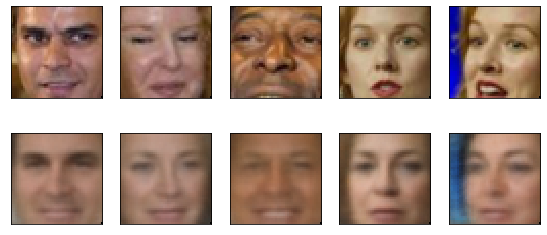

In [ ]:
reconstruction = np.rollaxis(cvae(x_val, labels_val)[2].detach().cpu().numpy(), 1, 4)
plot_gallery(np.concatenate([np.rollaxis(x_val.detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)

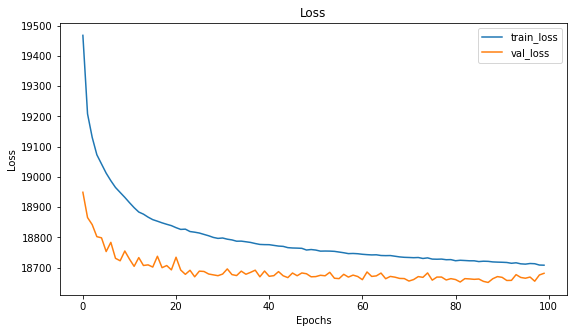

In [ ]:
visualize(train_losses, val_losses)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

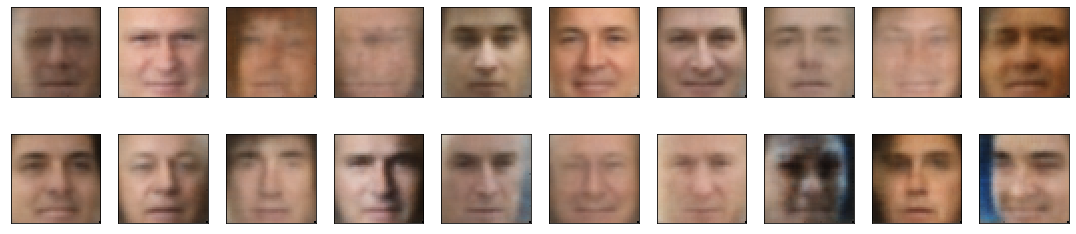

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
class_label = torch.zeros(20)
z = torch.FloatTensor(np.random.normal(0, 1, (20, 100, 1, 1))) # <latent_space_dim> = 100x1x1
z = torch.cat([z.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3).to(device)
output = cvae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=10)

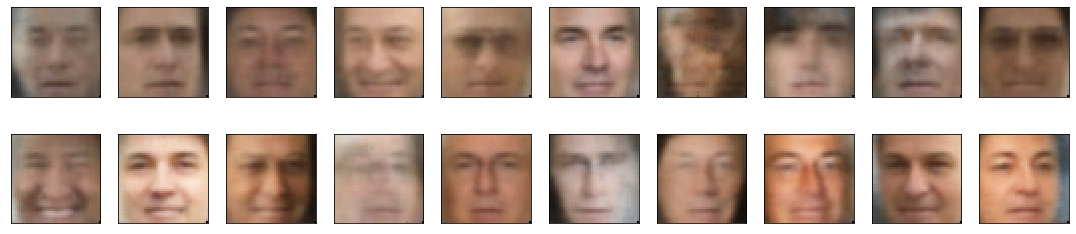

In [ ]:
class_label = torch.zeros(20)
z = torch.FloatTensor(np.random.normal(0, 1, (20, 100, 1, 1))) # <latent_space_dim> = 100x1x1
z = torch.cat([z.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3).to(device)
output = cvae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=10)

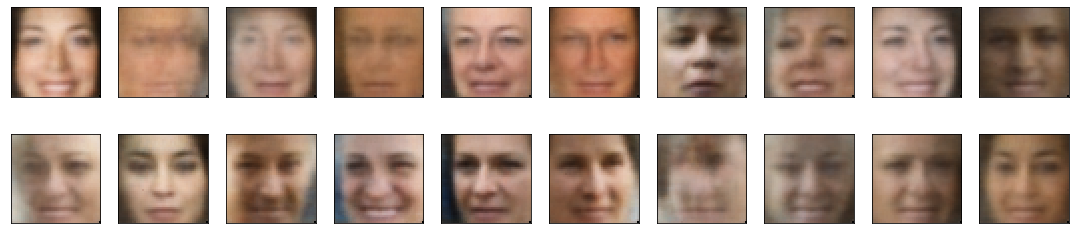

In [ ]:
class_label = torch.ones(20)
z = torch.FloatTensor(np.random.normal(0, 1, (20, 100, 1, 1))) # <latent_space_dim> = 100x1x1
z = torch.cat([z.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3).to(device)
output = cvae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=10)

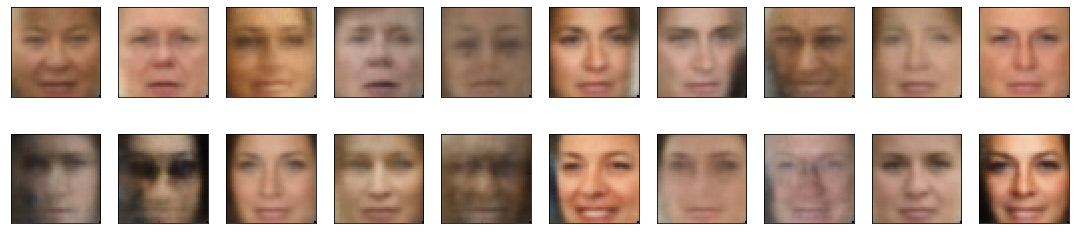

In [ ]:
class_label = torch.ones(20)
z = torch.FloatTensor(np.random.normal(0, 1, (20, 100, 1, 1))) # <latent_space_dim> = 100x1x1
z = torch.cat([z.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3).to(device)
output = cvae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=10)

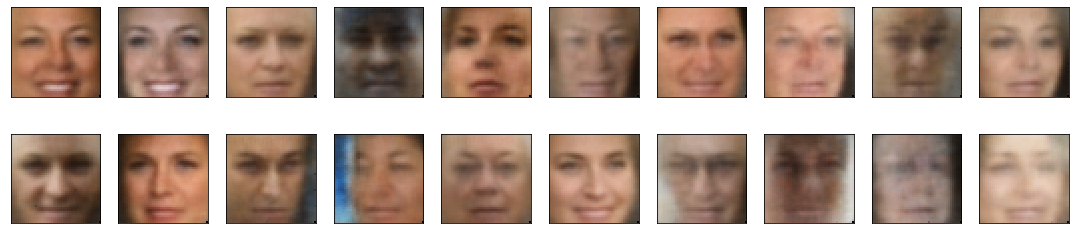

In [ ]:
class_label = torch.ones(20)
z = torch.FloatTensor(np.random.normal(0, 1, (20, 100, 1, 1))) # <latent_space_dim> = 100x1x1
z = torch.cat([z.squeeze(3).squeeze(2), class_label.unsqueeze(1)], dim=1).unsqueeze(2).unsqueeze(3).to(device)
output = cvae.decode(z) # <скормите z декодеру>
plot_gallery(np.rollaxis(output.data.cpu().numpy(), 1, 4), h=45, w=45, n_row=2, n_col=10)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

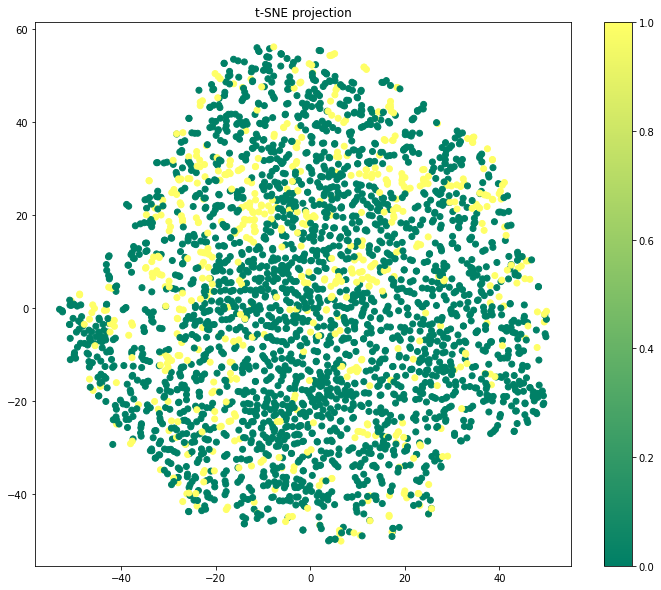

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
latent_vecs = pd.DataFrame()
cvae.eval()
for i, X_val_batch_ in enumerate(val_dataloader):
  X_val_batch = X_val_batch_['A'].to(device)
  labels_val_batch = X_val_batch_['B'].to(device)
  mu, logsigma = cvae.encode(X_val_batch)
  encoded = cvae.gaussian_sampler(mu, logsigma, labels_val_batch).detach().squeeze(3).squeeze(2).cpu().numpy()
  if i == 0:
    encoded_to_conc = encoded
  else:
    encoded_to_conc = np.concatenate((encoded_to_conc, encoded), axis=0)
  X_val_batch.cpu()
  labels_val_batch.cpu()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_to_conc)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=val_male_class, cmap = 'summer')
plt.colorbar()
plt.title('t-SNE projection')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('gdrive/My Drive/vanilla_autoencoder200epoch.pth'))

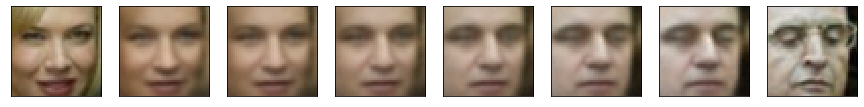

In [ ]:
# <тут ваш код>
autoencoder.eval()
val_dataset = ImageDataset(X=X_val)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

X = next(iter(val_dataloader)).to(device)
Y = next(iter(val_dataloader)).to(device)

latent_X = autoencoder.encoder(X)
latent_Y = autoencoder.encoder(Y)

pic = np.rollaxis(Y.detach().cpu().numpy(), 1, 4)
for i in range(6):
  alpha = 0.2 * i
  morph_pic = np.rollaxis(autoencoder.decoder(alpha*latent_X + (1 - alpha)*latent_Y).detach().cpu().numpy(), 1, 4)
  pic = np.concatenate([pic, morph_pic], axis=0)

pic = np.concatenate([pic, np.rollaxis(X.detach().cpu().numpy(), 1, 4)], axis=0)
plot_gallery(pic, h=45, w=45, n_row=1, n_col=8)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
def add_noise(X, noise_factor=0.5, mean=0., std=20.):
  return X + torch.FloatTensor(noise_factor * np.random.normal(loc=mean, scale=std, size=X.size()))

In [ ]:
noise_factor = 0.5
X_train_noisy = add_noise(X_train) 
X_val_noisy = add_noise(X_val) 

In [ ]:
class DImageDataset(Dataset):
    def __init__(self, X, X_damaged):
        self.X = X
        self.X_damaged = X_damaged

    def __getitem__(self, index):
        item_X = self.X[index, :, :, :] / 255
        item_X_damaged = self.X_damaged[index, :, :, :] / 255
        return {'A': item_X_damaged, 'B': item_X}

    def __len__(self):
        return self.X.size()[0]

In [ ]:
batch_size = 5

ntrain_dataset = DImageDataset(X=X_train, X_damaged=X_train_noisy)
nval_dataset = DImageDataset(X=X_val, X_damaged=X_val_noisy)

ntrain_dataloader = torch.utils.data.DataLoader(ntrain_dataset, batch_size=batch_size, shuffle=True)
nval_dataloader = torch.utils.data.DataLoader(nval_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.MSELoss() 
denoise_autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(denoise_autoencoder.parameters(), lr=1e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|Epoch 200/200| |Time_left: 0:00:35.190881|


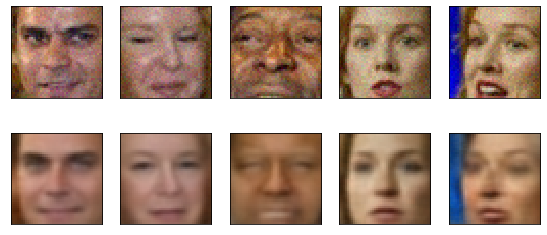

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
num_epoch = 200

train_losses = []
val_losses = []

prev_time = time()

x_val = next(iter(nval_dataloader))['A'].to(device)

for epoch in range(num_epoch):
    epoch_train_losses = []
    for X_train_batch in ntrain_dataloader:
      X_noisy_train_batch = X_train_batch['A'].to(device)
      X_true_train_batch = X_train_batch['B'].to(device)
      denoise_autoencoder.train()
      optimizer.zero_grad()
      rec_img = denoise_autoencoder(X_noisy_train_batch)
      train_loss = criterion(rec_img, X_true_train_batch)
      train_loss.backward()
      optimizer.step()
      epoch_train_losses.append(train_loss.item())
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for X_val_batch in nval_dataloader:
        X_noisy_val_batch = X_val_batch['A'].to(device)
        X_true_val_batch = X_val_batch['B'].to(device)
        denoise_autoencoder.eval()
        pred_img = denoise_autoencoder(X_noisy_val_batch)
        val_loss = criterion(pred_img, X_true_val_batch)
        epoch_val_losses.append(val_loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    
    clear_output(wait=True)
    time_left = datetime.timedelta(seconds=(num_epoch - epoch)*(time() - prev_time))
    prev_time = time()
    print("\r|Epoch {}/{}| |Time_left: {}|". \
          format(epoch+1,
                num_epoch,
                time_left
      )
    )
    reconstruction = np.rollaxis(denoise_autoencoder(x_val).detach().cpu().numpy(), 1, 4)
    plot_gallery(np.concatenate([np.rollaxis(x_val.detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)

In [ ]:
torch.save(denoise_autoencoder.state_dict(), "gdrive/My Drive/denoise_autoencoder200epoch.pth")

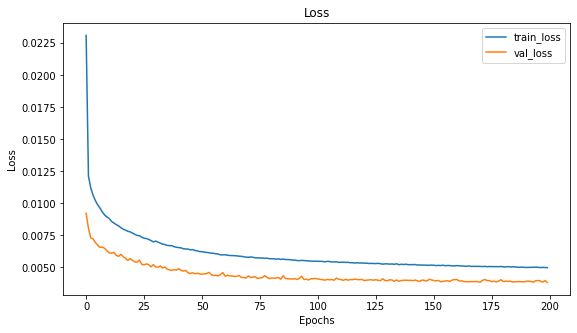

In [ ]:
visualize(train_losses, val_losses)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

In [ ]:
def occlusion(X):
    for pic_idx in range(X.size()[0]):
      p1 = np.random.randint(low=5, high=15)
      p2 = np.random.randint(low=5, high=15)
      t1 = np.random.randint(low=8, high=37)
      t2 = np.random.randint(low=8, high=37)
      X[pic_idx, :, t1:(t1+p1), t2:(t2+p2)] = 1.
    return X

In [ ]:
X_train_occluded = torch.Tensor(X_train.size()).copy_(X_train)
X_val_occluded = torch.Tensor(X_val.size()).copy_(X_val)

In [ ]:
X_train_ocluded = occlusion(X_train_occluded)
X_val_ocluded = occlusion(X_val_occluded)

In [ ]:
batch_size = 5

otrain_dataset = DImageDataset(X=X_train, X_damaged=X_train_occluded)
oval_dataset = DImageDataset(X=X_val, X_damaged=X_val_occluded)

otrain_dataloader = torch.utils.data.DataLoader(otrain_dataset, batch_size=batch_size, shuffle=True)
oval_dataloader = torch.utils.data.DataLoader(oval_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.MSELoss() 
occluded_autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(occluded_autoencoder.parameters(), lr=1e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|Epoch 200/200| |Time_left: 0:00:35.200161|


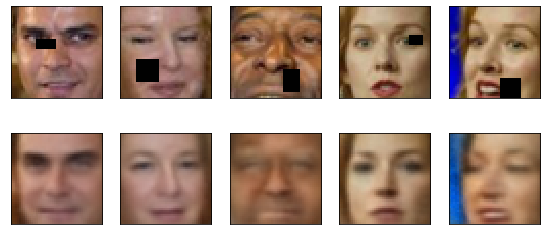

In [ ]:
num_epoch = 200

train_losses = []
val_losses = []

prev_time = time()

x_val = next(iter(oval_dataloader))['A'].to(device)

for epoch in range(num_epoch):
    epoch_train_losses = []
    for X_train_batch in otrain_dataloader:
      X_occluded_train_batch = X_train_batch['A'].to(device)
      X_true_train_batch = X_train_batch['B'].to(device)
      occluded_autoencoder.train()
      optimizer.zero_grad()
      rec_img = occluded_autoencoder(X_occluded_train_batch)
      train_loss = criterion(rec_img, X_true_train_batch)
      train_loss.backward()
      optimizer.step()
      epoch_train_losses.append(train_loss.item())
    train_losses.append(np.mean(epoch_train_losses))

    epoch_val_losses = []
    for X_val_batch in oval_dataloader:
        X_occluded_val_batch = X_val_batch['A'].to(device)
        X_true_val_batch = X_val_batch['B'].to(device)
        occluded_autoencoder.eval()
        pred_img = occluded_autoencoder(X_occluded_val_batch)
        val_loss = criterion(pred_img, X_true_val_batch)
        epoch_val_losses.append(val_loss.item())
    val_losses.append(np.mean(epoch_val_losses))
    
    clear_output(wait=True)
    time_left = datetime.timedelta(seconds=(num_epoch - epoch)*(time() - prev_time))
    prev_time = time()
    print("\r|Epoch {}/{}| |Time_left: {}|". \
          format(epoch+1,
                num_epoch,
                time_left
      )
    )
    reconstruction = np.rollaxis(occluded_autoencoder(x_val).detach().cpu().numpy(), 1, 4)
    plot_gallery(np.concatenate([np.rollaxis(x_val.detach().cpu().numpy(), 1, 4), reconstruction]), h=45, w=45, n_row=2, n_col=5)

In [ ]:
torch.save(occluded_autoencoder.state_dict(), "gdrive/My Drive/occluded_autoencoder200epoch.pth")

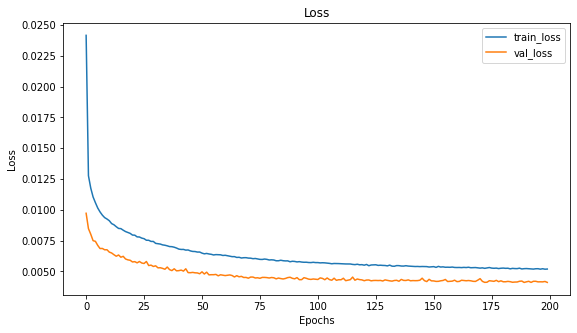

In [ ]:
visualize(train_losses, val_losses)

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
batch_size = 5

train_dataset = ImageDataset(X=X_train)
val_dataset = ImageDataset(X=X_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
vae = VAE().to(device)

In [ ]:
vae.load_state_dict(torch.load('gdrive/My Drive/vae_autoencoder100epoch.pth'))

In [ ]:
# codes = <поучите латентные представления картинок из трейна>
vae.eval()
for i, X_train_batch in enumerate(train_dataloader):
  X_train_batch = X_train_batch.to(device)
  mu, logsigma = vae.encode(X_train_batch)
  encoded = vae.gaussian_sampler(mu, logsigma).detach().squeeze(3).squeeze(2).cpu().numpy()
  if i == 0:
    encoded_to_conc = encoded
  else:
    encoded_to_conc = np.concatenate((encoded_to_conc, encoded), axis=0)
  X_train_batch.cpu()

In [ ]:
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors().fit(encoded_to_conc)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  mu, logsigma = vae.encode(image)
  code = vae.gaussian_sampler(mu, logsigma)
  code = code.detach().squeeze(3).squeeze(2).cpu().numpy()

  distances, idx = lshf.kneighbors(code, n_neighbors=n_neighbors, return_distance=True)

  return distances, idx

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors_idx = get_similar(image, n_neighbors=11)
    
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.squeeze(0).cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    plt.xticks(())
    plt.yticks(())

    for i in range(11):
        plt.subplot(3,4,i+2)
        neighbor = X_train[neighbors_idx[0][i]] / 255
        plt.imshow(neighbor.cpu().numpy().transpose([1,2,0]))
        plt.xticks(())
        plt.yticks(())
        plt.title("Dist=%.3f"%distances[0][i])
    plt.show()

<Figure size 432x288 with 0 Axes>

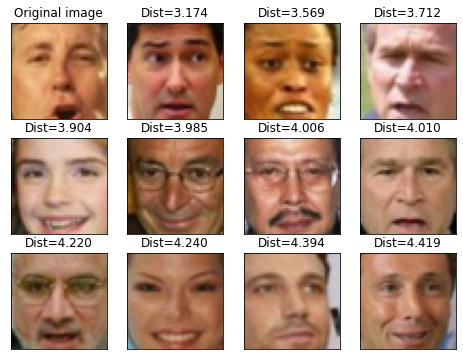

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

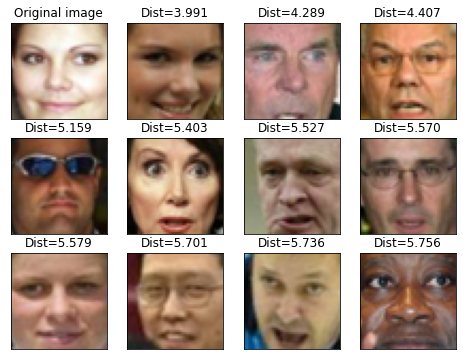

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

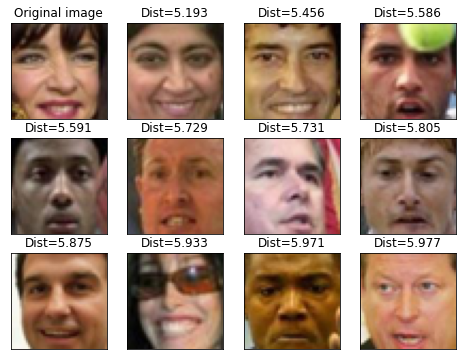

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

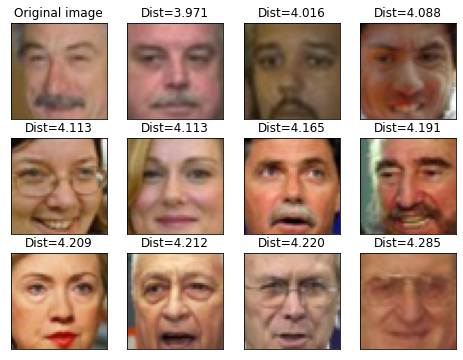

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

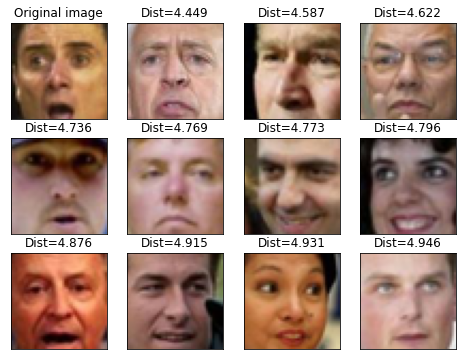

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

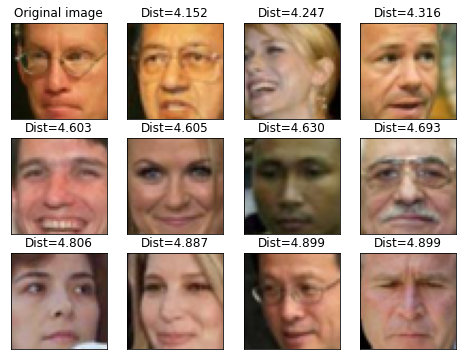

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

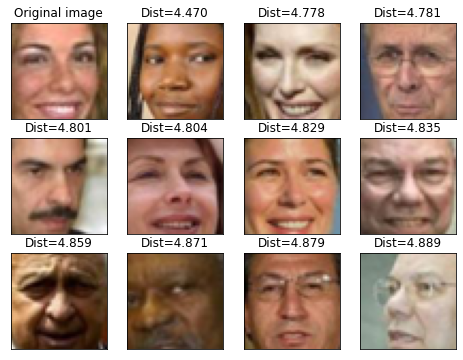

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

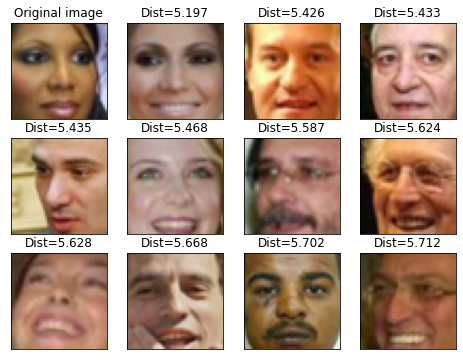

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

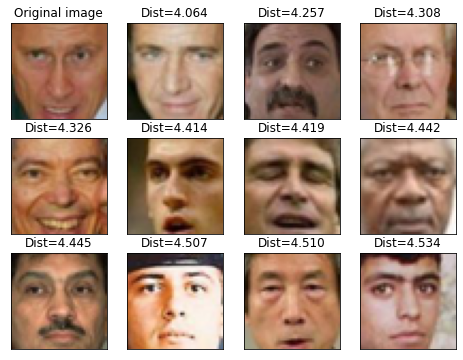

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

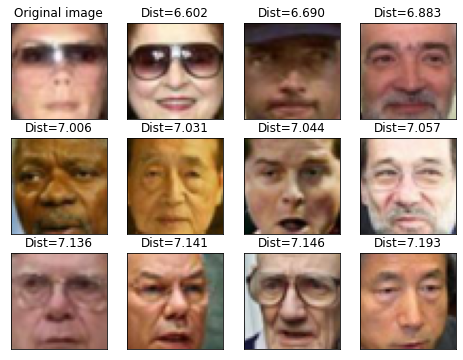

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

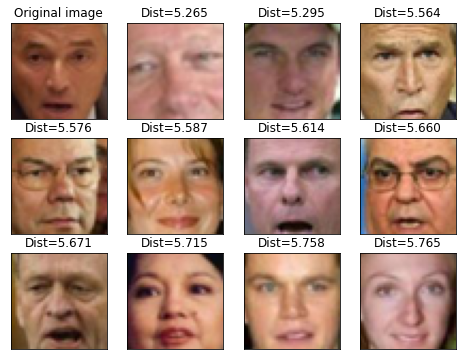

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

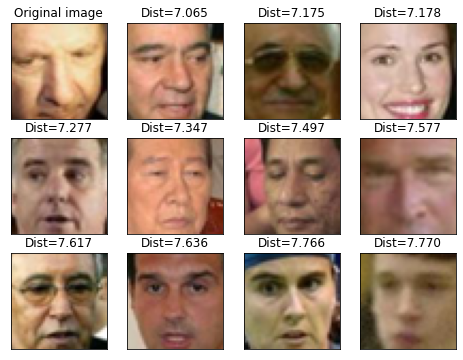

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

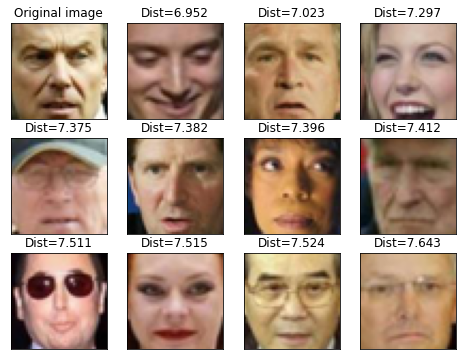

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

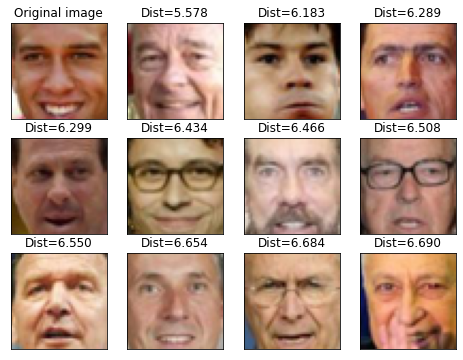

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

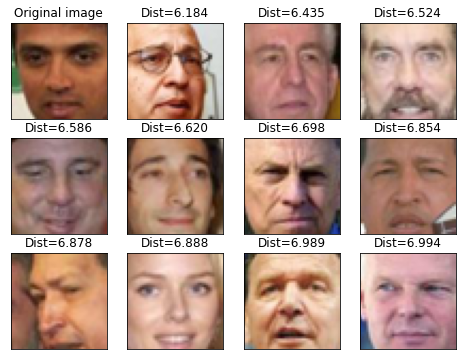

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

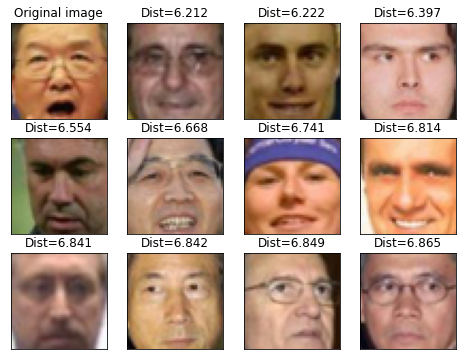

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

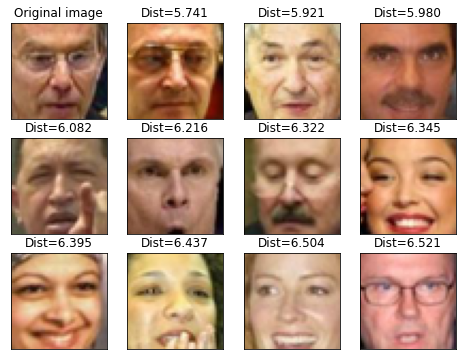

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

<Figure size 432x288 with 0 Axes>

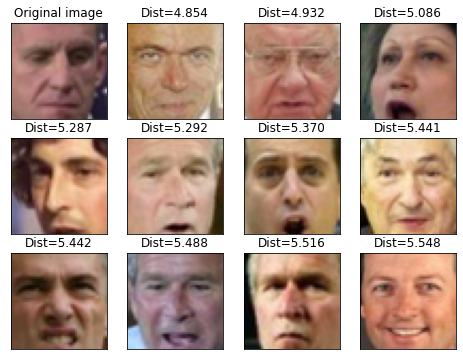

In [ ]:
image = next(iter(val_dataloader)).to(device)
show_similar(image)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!